In [145]:
from pathlib import Path
import argparse
import json
import math
import os
import sys
import time

import torch
import torch.nn.functional as F
from torch import nn, optim
import torch.distributed as dist
import torchvision.datasets as datasets
from PIL import ImageOps, ImageFilter

import torchvision
from torchvision import transforms
import numpy as np

import augmentations as aug
from distributed import init_distributed_mode

import resnet
import torchinfo

import matplotlib.pyplot as plt

from torchinfo import summary

from tqdm import tqdm

import pandas as pd
#Mean cifar
# array([0.49139968, 0.48215841, 0.44653091])
#Std cifar
# array([0.24703223, 0.24348513, 0.26158784])

# Inspect training

In [149]:
epoch_path = "exp4\stats_epoch.txt"
dict_list_train = []
dict_list_eval_acc = []
dict_list_eval_loss = []
training = True

with open(epoch_path, "r") as f:
    epoch_stats = f.readlines()
    for line in epoch_stats:

        # Check if .\evaluate.py is starting
        if line.__contains__("evaluate.py"):
            training = False

        if line[0] == "{" and training:
            #Convert string to dict
            line = dict(eval(line))
            dict_list_train.append(line)

df_train = pd.DataFrame(dict_list_train)


stats_path = "exp4\stats.txt"
with open(stats_path, "r") as f:
    epoch_stats = f.readlines()
    for line in epoch_stats:

        # Check if .\evaluate.py is starting
        if line.__contains__("evaluate.py"):
            training = False

        if line.__contains__("main_vicreg.py"):
            training = True

        elif line[0] == "{" and not training:
            #Convert string to dict
            line = dict(eval(line))
            #Check if acc1 is in dict
            if "acc1" in line:
                dict_list_eval_acc.append(line)
            else:
                dict_list_eval_loss.append(line)

df_eval_loss = pd.DataFrame(dict_list_eval_loss)
df_eval_acc = pd.DataFrame(dict_list_eval_acc)

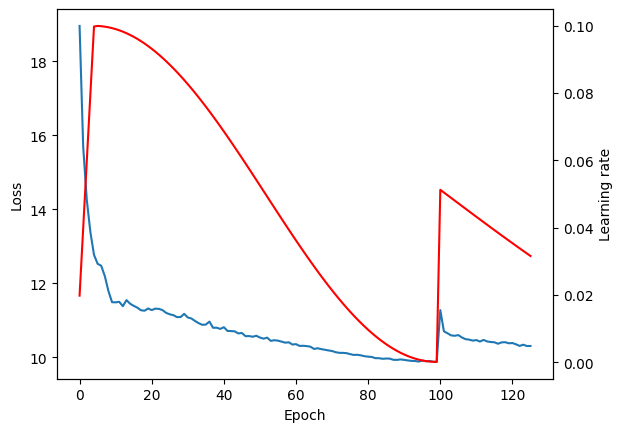

In [150]:
fig, ax = plt.figure(), plt.gca()
ax.plot(df_train["epoch"], df_train["loss"], label="train_loss")
#Twin object for two different y-axis on the sample plot
ax2=ax.twinx()
#make a plot with different y-axis using second axis object
ax2.plot(df_train["epoch"], df_train["lr"], color="r", label="val_loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax2.set_ylabel("Learning rate")
# plt.xlim(20, 100)
plt.show()

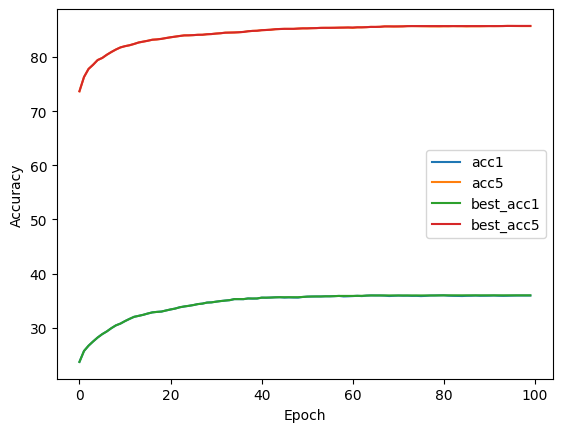

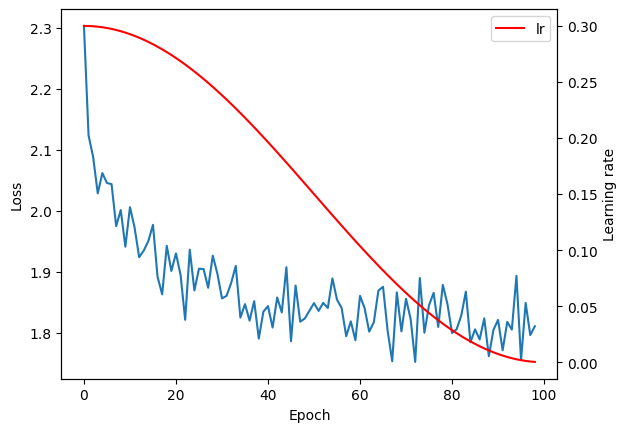

In [151]:
plt.plot(df_eval_acc["epoch"], df_eval_acc["acc1"], label="acc1")
plt.plot(df_eval_acc["epoch"], df_eval_acc["acc5"], label="acc5")
plt.plot(df_eval_acc["epoch"], df_eval_acc["best_acc1"], label="best_acc1")
plt.plot(df_eval_acc["epoch"], df_eval_acc["best_acc5"], label="best_acc5")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


fig,ax = plt.subplots()
ax.plot(df_eval_loss["epoch"], df_eval_loss["loss"], label="loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax2 = ax.twinx()
ax2.plot(df_eval_loss["epoch"], df_eval_loss["lr_head"], color="r", label="lr")
ax2.set_ylabel("Learning rate")
plt.legend()
plt.show()


# Check dataset torch same as homemade

In [5]:
from PIL import Image

In [9]:
transform = aug.TrainTransform()


In [26]:
dataset_torch = datasets.CIFAR10(root="~/data",transform=transform, download=True)
dataset = datasets.ImageFolder("../data/cifar10"+ "/train_100", transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0, pin_memory=True)
loader_torch = torch.utils.data.DataLoader(dataset_torch, batch_size=1024)

Files already downloaded and verified


In [19]:
def adjust_learning_rate(epochs,batch_size,base_lr, loader, step):
    max_steps = epochs * len(loader)
    warmup_steps = 5 * len(loader)
    base_lr = base_lr * batch_size / 256
    if step < warmup_steps:
        lr = base_lr * step / warmup_steps
    else:
        step -= warmup_steps
        max_steps -= warmup_steps
        q = 0.5 * (1 + math.cos(math.pi * step / max_steps))
        end_lr = base_lr * 0.001
        lr = base_lr * q + end_lr * (1 - q)
    # for param_group in optimizer.param_groups:
    #     param_group["lr"] = lr
    return lr

In [22]:
epochs = 100
batch_size = 1024
base_lr = 0.2

step_list = np.arange(0, epochs*len(loader), 1)
lr_list = []
for step in step_list:
    lr = adjust_learning_rate(epochs,batch_size,base_lr, loader, step)
    lr_list.append(lr)

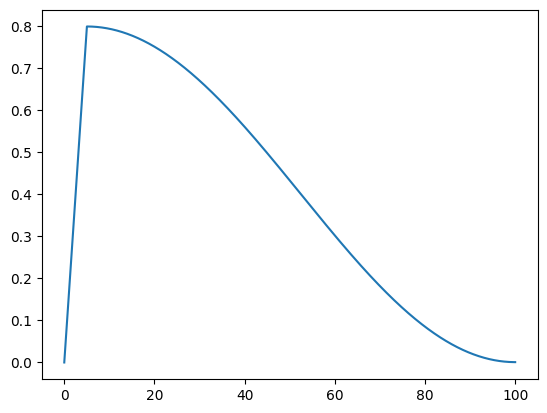

In [24]:
#From steps to epoch number
epoch_list = []
for step in step_list:
    epoch = step / len(loader)
    epoch_list.append(epoch)

plt.plot(epoch_list, lr_list)



# Aug ISIC

In [40]:
# Load isic dataset
import torchvision.transforms as transforms
t = transforms.ToTensor()
dataset = datasets.ImageFolder("../data/ISIC"+ "/train_100", t)

In [120]:
# Set of transforms
## Crop along the main axis
class CropMainAxis:

    def __call__(self, img):
        print(len(img))
        c,w, h = img.size()
        return transforms.CenterCrop(1.1*min(w, h))(img)

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 0.5 + 0.1
            return img.filter(ImageFilter.GaussianBlur(sigma))
        else:
            return img

class LambdaTransform(object):

    def __call__(self, img):
        print(img)
        return img

isic_mean = torch.tensor([0.6116, 0.4709, 0.4692])
isic_std = torch.tensor([0.2560, 0.2217, 0.2273])

t_train = transforms.Compose([
    transforms.ToTensor(),
    CropMainAxis(),
    transforms.Resize((224, 224)),
    transforms.ToPILImage(),
    # transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(360),
    GaussianBlur(0.5),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.)
        ], p=0.8),
    transforms.ToTensor(),
    # transforms.Normalize(isic_mean, isic_std),
    
])  

t_stats = transforms.Compose([
    transforms.ToTensor(),
    CropMainAxis(),
    transforms.Resize((224, 224)),
])

In [121]:
isic_mean = torch.tensor([0.6116, 0.4709, 0.4692])
isic_std = torch.tensor([0.2560, 0.2217, 0.2273])

In [122]:
stats_dataset = datasets.ImageFolder("../data/ISIC"+ "/train_100", t_stats)

In [123]:
if False:
    #Compute mean and std on the dataset
    from tqdm import tqdm
    loader= torch.utils.data.DataLoader(stats_dataset, batch_size=128)

    mean = 0.
    std = 0.
    nb_samples = 0.
    for data,_ in tqdm(loader, total=len(loader)):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

In [124]:
dataset = datasets.ImageFolder("../data/ISIC"+ "/train_100", t_train)

3


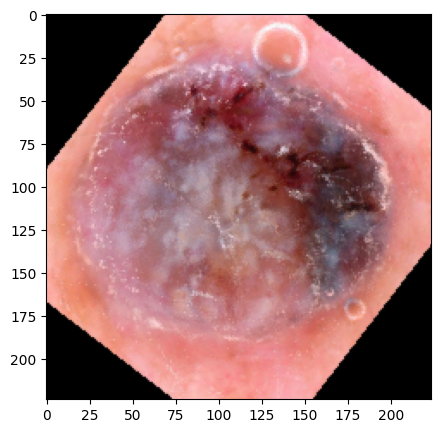

In [144]:
res = dataset[2][0]
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.imshow(res.permute(1, 2, 0))
plt.show()



In [ ]:
cifar10_mean=[0.49139968, 0.48215841, 0.44653091]
cifar10_std=[0.24703223, 0.24348513, 0.26158784]

class Train_eval_transform():
    def __call__(self,img):
        t = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(cifar10_mean, cifar10_std),
        ])
        return t(img)

# Smaller backbone

# Res.py code 

In [302]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import torch
import torch.nn as nn


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ["downsample"]

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
        last_activation="relu",
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # if groups != 1 or base_width != 64:
        #     raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ["downsample"]

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
        last_activation="relu",
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if last_activation == "relu":
            self.last_activation = nn.ReLU(inplace=True)
        elif last_activation == "none":
            self.last_activation = nn.Identity()
        elif last_activation == "sigmoid":
            self.last_activation = nn.Sigmoid()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.last_activation(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_channels=3,
        zero_init_residual=False,
        groups=1,
        widen=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
        last_activation="relu",
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # self._last_activation = last_activation

        self.padding = nn.ConstantPad2d(1, 0.0)

        self.inplanes = width_per_group * widen
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # change padding 3 -> 2 compared to original torchvision code because added a padding layer
        num_out_filters = width_per_group * widen
        self.conv1 = nn.Conv2d(
            num_channels,
            num_out_filters,
            kernel_size=7,
            stride=2,
            padding=2,
            bias=False,
        )
        self.bn1 = norm_layer(num_out_filters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, num_out_filters, layers[0])
        num_out_filters *= 2
        self.layer2 = self._make_layer(
            block,
            num_out_filters,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0],
        )
        num_out_filters *= 2
        self.layer3 = self._make_layer(
            block,
            num_out_filters,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1],
        )
        num_out_filters *= 2
        self.layer4 = self._make_layer(
            block,
            num_out_filters,
            layers[3],
            stride=2,
            dilate=replace_stride_with_dilation[2],
            last_activation=last_activation,
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(
        self, block, planes, blocks, stride=1, dilate=False, last_activation="relu"
    ):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
                last_activation=(last_activation if blocks == 1 else "relu"),
            )
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                    last_activation=(last_activation if i == blocks - 1 else "relu"),
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.padding(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

class Net(nn.Module):
    def __init__(
        self,
        num_channels=3,
        channels=64,
        out_channels=32,
        zero_init_residual=False,):

        super(Net,self).__init__()
        self.block1 = BasicBlock(num_channels,channels,downsample=conv1x1(num_channels,channels,1))
        self.block2 = BasicBlock(channels,2*channels,2,downsample=conv1x1(channels,2*channels,2))
        self.block3 = BasicBlock(2*channels,channels,2,downsample=conv1x1(2*channels,channels,2))
        self.block4 = BasicBlock(channels,out_channels,2,downsample=conv1x1(channels,out_channels,2))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)    
    
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x


class ConvBNReLU(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,stride=1,padding=1):
        super(ConvBNReLU,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class CNN_cifar(nn.Module):
    def __init__(self,in_channels=3,out_channels=64,zero_init_residual=False):
        super(CNN_cifar,self).__init__()

        self.conv1 = ConvBNReLU(in_channels,32,3,1,1) 
        self.conv2 = ConvBNReLU(32,64,3,2,1)
        self.conv3 = ConvBNReLU(64,64,3,2,1)
        self.conv4 = ConvBNReLU(64,out_channels,3,1,1)

        self.dropout = nn.Dropout(0.5)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)        
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x



def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs), 512


def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs), 2048


def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs), 2048


def resnet50x2(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], widen=2, **kwargs), 4096


def resnet50x4(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], widen=4, **kwargs), 8192


def resnet50x5(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], widen=5, **kwargs), 10240


def resnet200x2(**kwargs):
    return ResNet(Bottleneck, [3, 24, 36, 3], widen=2, **kwargs), 4096


def small_cnn(**kwargs):
    return Net(**kwargs), 32

def cnn_cifar(**kwargs):
    return CNN_cifar(**kwargs), 64

In [310]:
class ResNet_CIFAR10(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_channels=3,
        zero_init_residual=False,
        groups=1,
        widen=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
        last_activation="relu",
    ):
        super(ResNet_CIFAR10, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # self._last_activation = last_activation

        self.padding = nn.ConstantPad2d(1, 0.0)

        self.inplanes = width_per_group * widen
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # change padding 3 -> 2 compared to original torchvision code because added a padding layer
        num_out_filters = width_per_group * widen
        # self.conv1 = nn.Conv2d(
        #     num_channels,
        #     num_out_filters,
        #     kernel_size=7,
        #     stride=2,
        #     padding=2,
        #     bias=False,
        # )
        self.conv1 = conv3x3(num_channels, num_out_filters, stride=1)
        self.bn1 = norm_layer(num_out_filters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, num_out_filters, layers[0])
        num_out_filters *= 2
        self.layer2 = self._make_layer(
            block,
            num_out_filters,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0],
        )
        num_out_filters *= 2
        self.layer3 = self._make_layer(
            block,
            num_out_filters,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1],
        )
        num_out_filters *= 2
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(
        self, block, planes, blocks, stride=1, dilate=False, last_activation="relu"
    ):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
                last_activation=(last_activation if blocks == 1 else "relu"),
            )
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                    last_activation=(last_activation if i == blocks - 1 else "relu"),
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        # x = self.padding(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

In [327]:
m =ResNet_CIFAR10(BasicBlock,[5,5,5],width_per_group=64)# ResNet_CIFAR10(BasicBlock,[5,5,5],width_per_group=16)
summary(m,(5,3,32,32),device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_CIFAR10                           [5, 256]                  --
├─Conv2d: 1-1                            [5, 64, 32, 32]           1,728
├─BatchNorm2d: 1-2                       [5, 64, 32, 32]           128
├─ReLU: 1-3                              [5, 64, 32, 32]           --
├─Sequential: 1-4                        [5, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [5, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [5, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [5, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [5, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [5, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-5             [5, 64, 32, 32]           128
│    │    └─ReLU: 3-6                    [5, 64, 32, 32]           --
│    └─BasicBlock: 2-2                   [5, 64, 32, 32]           --
│

# Resnet cifar10

In [35]:
m = torchvision.models.vgg11().features
summary(m, input_size=(256,3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 7, 7]            --
├─Conv2d: 1-1                            [1, 64, 224, 224]         1,792
├─ReLU: 1-2                              [1, 64, 224, 224]         --
├─MaxPool2d: 1-3                         [1, 64, 112, 112]         --
├─Conv2d: 1-4                            [1, 128, 112, 112]        73,856
├─ReLU: 1-5                              [1, 128, 112, 112]        --
├─MaxPool2d: 1-6                         [1, 128, 56, 56]          --
├─Conv2d: 1-7                            [1, 256, 56, 56]          295,168
├─ReLU: 1-8                              [1, 256, 56, 56]          --
├─Conv2d: 1-9                            [1, 256, 56, 56]          590,080
├─ReLU: 1-10                             [1, 256, 56, 56]          --
├─MaxPool2d: 1-11                        [1, 256, 28, 28]          --
├─Conv2d: 1-12                           [1, 512, 28, 28]          1

In [20]:
class CNN_cifar(nn.Module):
    def __init__(self,in_channels=3,out_channels=64):
        super(CNN_cifar,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,32,3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,stride=2,padding=1)
        self.conv3 = nn.Conv2d(64,64,3,stride=2,padding=1)
        self.conv4 = nn.Conv2d(64,out_channels,3,stride=1,padding=1)

        self.dropout = nn.Dropout(0.5)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

In [21]:
m= CNN_cifar()
summary(m, input_size=(5,3, 32, 32), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
CNN_cifar                                [5, 128]                  --
├─Conv2d: 1-1                            [5, 32, 32, 32]           896
├─BatchNorm2d: 1-2                       [5, 32, 32, 32]           64
├─ReLU: 1-3                              [5, 32, 32, 32]           --
├─Dropout: 1-4                           [5, 32, 32, 32]           --
├─Conv2d: 1-5                            [5, 64, 16, 16]           18,496
├─BatchNorm2d: 1-6                       [5, 64, 16, 16]           128
├─ReLU: 1-7                              [5, 64, 16, 16]           --
├─Dropout: 1-8                           [5, 64, 16, 16]           --
├─Conv2d: 1-9                            [5, 64, 8, 8]             36,928
├─BatchNorm2d: 1-10                      [5, 64, 8, 8]             128
├─ReLU: 1-11                             [5, 64, 8, 8]             --
├─Dropout: 1-12                          [5, 64, 8, 8]             --
├─Co

In [290]:
m = resnet.ResNet(resnet.BasicBlock, [5, 0, 0,8])
summary(m, input_size=(5,3, 32, 32), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [5, 512]                  --
├─ConstantPad2d: 1-1                     [5, 3, 34, 34]            --
├─Conv2d: 1-2                            [5, 64, 16, 16]           9,408
├─BatchNorm2d: 1-3                       [5, 64, 16, 16]           128
├─ReLU: 1-4                              [5, 64, 16, 16]           --
├─MaxPool2d: 1-5                         [5, 64, 8, 8]             --
├─Sequential: 1-6                        [5, 64, 8, 8]             --
│    └─BasicBlock: 2-1                   [5, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [5, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [5, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [5, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [5, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [5, 64, 8, 8]             128
│

# YEs

In [29]:
parser = argparse.ArgumentParser(description="Pretrain a resnet model with VICReg", add_help=False)
args = dict()



# Data
parser.add_argument("--data-dir", type=Path, default="../data/cifar10", required=True,
                    help='Path to the image net dataset')
args['data_dir'] = Path('../data/cifar10')
# Checkpoints
parser.add_argument("--exp-dir", type=Path, default="./exp",
                    help='Path to the experiment folder, where all logs/checkpoints will be stored')
parser.add_argument("--log-freq-time", type=int, default=60,
                    help='Print logs to the stats.txt file every [log-freq-time] seconds')
args['exp_dir'] = Path('./exp')
args['log_freq_time'] = 60
# Model
parser.add_argument("--arch", type=str, default="resnet50",
                    help='Architecture of the backbone encoder network')
parser.add_argument("--mlp", default="8192-8192-8192",
                    help='Size and number of layers of the MLP expander head')
args['arch'] = 'resnet34'
args['mlp'] = '2048-2048-2048'

# Optim
parser.add_argument("--epochs", type=int, default=100,
                    help='Number of epochs')
parser.add_argument("--batch-size", type=int, default=2048,
                    help='Effective batch size (per worker batch size is [batch-size] / world-size)')
parser.add_argument("--base-lr", type=float, default=0.2,
                    help='Base learning rate, effective learning after warmup is [base-lr] * [batch-size] / 256')
parser.add_argument("--wd", type=float, default=1e-6,
                    help='Weight decay')

args['epochs'] = 2
args['batch_size'] = 1
args['base_lr'] = 0.2
args['wd'] = 1e-6

# Loss
parser.add_argument("--sim-coeff", type=float, default=25.0,
                    help='Invariance regularization loss coefficient')
parser.add_argument("--std-coeff", type=float, default=25.0,
                    help='Variance regularization loss coefficient')
parser.add_argument("--cov-coeff", type=float, default=1.0,
                    help='Covariance regularization loss coefficient')

args['sim_coeff'] = 25.0
args['std_coeff'] = 25.0
args['cov_coeff'] = 1.0


# Running
parser.add_argument("--num-workers", type=int, default=10)
parser.add_argument('--device', default='cuda',
                    help='device to use for training / testing')

args['num_workers'] = 10
args['device'] = 'cuda'


# Distributed
parser.add_argument('--world-size', default=1, type=int,
                    help='number of distributed processes')
parser.add_argument('--local_rank', default=-1, type=int)
parser.add_argument('--dist-url', default='env://',
                    help='url used to set up distributed training')

args['world_size'] = 1
args['local_rank'] = -1
args['dist_url'] = 'env://'

class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
    
args = Struct(**args)
#print args attributes
for attr, value in args.__dict__.items():
    print(attr, value)

data_dir ..\data\cifar10
exp_dir exp
log_freq_time 60
arch resnet34
mlp 2048-2048-2048
epochs 2
batch_size 1
base_lr 0.2
wd 1e-06
sim_coeff 25.0
std_coeff 25.0
cov_coeff 1.0
num_workers 10
device cuda
world_size 1
local_rank -1
dist_url env://


## Data loading

In [30]:
transforms = aug.TrainTransform()

# train_dataset = datasets.ImageFolder(args.data_dir / "train", transforms)
train_dataset = torchvision.datasets.CIFAR10(root="~/data", train=True, download=True,transform = transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

Files already downloaded and verified


In [31]:
len(train_dataloader)

50000

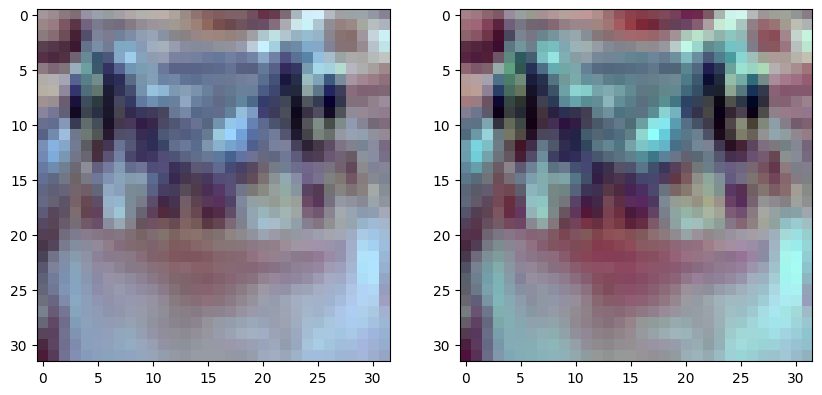

In [23]:
img_ex_x, img_ex_y = train_dataset[151][0]

def normalize(img):
    return (img-img.min())/(img.max()-img.min())

fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(normalize(img_ex_x).permute(1,2,0))
ax[1].imshow(normalize(img_ex_y).permute(1,2,0))


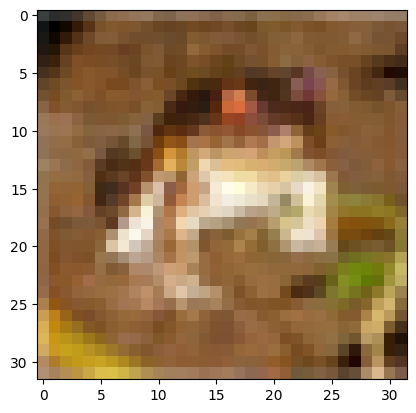

In [7]:
train_dataset.data[0]
plt.imshow(train_dataset.data[0])

In [8]:
(x,y),_ = next(iter(train_dataloader))

In [ ]:
print(x.shape)
plt.imshow(x[0].permute(1,2,0))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\cifar.py", line 118, in __getitem__
    img = self.transform(img)
  File "d:\Documents\MVA\Object recognition and Computer Vision\Final_Project\vicreg_perso\augmentations.py", line 90, in __call__
    x1 = self.transform(sample)
  File "c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py", line 94, in __call__
    img = t(img)
  File "c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py", line 192, in forward
    return F.convert_image_dtype(image, self.dtype)
  File "c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py", line 237, in convert_image_dtype
    raise TypeError("Input img should be Tensor Image")
TypeError: Input img should be Tensor Image


## Model definition

In [16]:
def exclude_bias_and_norm(p):
    return p.ndim == 1


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()



In [17]:
def Projector(args, embedding):
    mlp_spec = f"{embedding}-{args.mlp}"
    layers = []
    f = list(map(int, mlp_spec.split("-")))
    for i in range(len(f) - 2):
        layers.append(nn.Linear(f[i], f[i + 1]))
        layers.append(nn.BatchNorm1d(f[i + 1]))
        layers.append(nn.ReLU(True))
    layers.append(nn.Linear(f[-2], f[-1], bias=False))
    return nn.Sequential(*layers)

In [18]:
def adjust_learning_rate(args, optimizer, loader, step):
    max_steps = args.epochs * len(loader)
    warmup_steps = 10 * len(loader)
    base_lr = args.base_lr * args.batch_size / 256
    if step < warmup_steps:
        lr = base_lr * step / warmup_steps
    else:
        step -= warmup_steps
        max_steps -= warmup_steps
        q = 0.5 * (1 + math.cos(math.pi * step / max_steps))
        end_lr = base_lr * 0.001
        lr = base_lr * q + end_lr * (1 - q)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return lr

In [19]:
class LARS(optim.Optimizer):
    def __init__(
        self,
        params,
        lr,
        weight_decay=0,
        momentum=0.9,
        eta=0.001,
        weight_decay_filter=None,
        lars_adaptation_filter=None,
    ):
        defaults = dict(
            lr=lr,
            weight_decay=weight_decay,
            momentum=momentum,
            eta=eta,
            weight_decay_filter=weight_decay_filter,
            lars_adaptation_filter=lars_adaptation_filter,
        )
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for g in self.param_groups:
            for p in g["params"]:
                dp = p.grad

                if dp is None:
                    continue

                if g["weight_decay_filter"] is None or not g["weight_decay_filter"](p):
                    dp = dp.add(p, alpha=g["weight_decay"])

                if g["lars_adaptation_filter"] is None or not g[
                    "lars_adaptation_filter"
                ](p):
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(dp)
                    one = torch.ones_like(param_norm)
                    q = torch.where(
                        param_norm > 0.0,
                        torch.where(
                            update_norm > 0, (g["eta"] * param_norm / update_norm), one
                        ),
                        one,
                    )
                    dp = dp.mul(q)

                param_state = self.state[p]
                if "mu" not in param_state:
                    param_state["mu"] = torch.zeros_like(p)
                mu = param_state["mu"]
                mu.mul_(g["momentum"]).add_(dp)

                p.add_(mu, alpha=-g["lr"])

In [20]:
backbone = resnet.__dict__[args.arch](
            zero_init_residual=True
        )

In [21]:
class VICReg(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.num_features = int(args.mlp.split("-")[-1])
        self.backbone, self.embedding = resnet.__dict__[args.arch](
            zero_init_residual=True
        )
        self.projector = Projector(args, self.embedding)

    def forward(self, x, y):
        x = self.projector(self.backbone(x))
        y = self.projector(self.backbone(y))

        repr_loss = F.mse_loss(x, y)

        # x = torch.cat(FullGatherLayer.apply(x), dim=0)
        # y = torch.cat(FullGatherLayer.apply(y), dim=0)
        # x = torch.cat(x, dim=0)
        # y = torch.cat(y, dim=0)
        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x.T @ x) / (self.args.batch_size - 1)
        cov_y = (y.T @ y) / (self.args.batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
            self.num_features
        ) + off_diagonal(cov_y).pow_(2).sum().div(self.num_features)

        loss = (
            self.args.sim_coeff * repr_loss
            + self.args.std_coeff * std_loss
            + self.args.cov_coeff * cov_loss
        )
        return loss

In [22]:
model = VICReg(args)
model

VICReg(
  (backbone): ResNet(
    (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): B

## Train

In [ ]:
args.device

In [ ]:
args.exp_dir.mkdir(parents=True, exist_ok=True)
stats_file = open(args.exp_dir / "stats.txt", "a", buffering=1)
print(" ".join(sys.argv))
print(" ".join(sys.argv), file=stats_file)

In [ ]:
model = VICReg(args).to(args.device)

optimizer = LARS(
    model.parameters(),
    lr=0,
    weight_decay=args.wd,
    weight_decay_filter=exclude_bias_and_norm,
    lars_adaptation_filter=exclude_bias_and_norm,
)

In [ ]:
if (args.exp_dir / "model.pth").is_file():
    if args.rank == 0:
        print("resuming from checkpoint")
    ckpt = torch.load(args.exp_dir / "model.pth", map_location="cpu")
    start_epoch = ckpt["epoch"]
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
else:
    start_epoch = 0
print("start epoch", start_epoch)

In [ ]:
from tqdm import tqdm

start_time = last_logging = time.time()
scaler = torch.cuda.amp.GradScaler()
for epoch in range(start_epoch, args.epochs):
    print("epoch", epoch)
    # sampler.set_epoch(epoch)
    for step, ((x, y), _) in (p_bar:= tqdm(enumerate(train_dataloader, start=epoch * len(train_dataloader)), total=len(train_dataloader), desc=f"Epoch {epoch}")):
        # print("step", step)
        # x = x.cuda(gpu, non_blocking=True)
        # y = y.cuda(gpu, non_blocking=True)

        x = x.to(args.device)
        y = y.to(args.device)

        lr = adjust_learning_rate(args, optimizer, train_dataloader, step)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = model.forward(x, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        p_bar.set_postfix({"loss": loss.item()})

        current_time = time.time()
        if current_time - last_logging > args.log_freq_time:
            stats = dict(
                epoch=epoch,
                step=step,
                loss=loss.item(),
                time=int(current_time - start_time),
                lr=lr,
            )
            print(json.dumps(stats))
            print(json.dumps(stats), file=stats_file)
            last_logging = current_time

In [21]:
def main(args):
    print(args)
    gpu = torch.device(args.device)

    args.exp_dir.mkdir(parents=True, exist_ok=True)
    stats_file = open(args.exp_dir / "stats.txt", "a", buffering=1)
    print(" ".join(sys.argv))
    print(" ".join(sys.argv), file=stats_file)

    transforms = aug.TrainTransform()

    dataset = datasets.ImageFolder(args.data_dir / "train", transforms)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=True,
    )

    model = VICReg(args).cuda(gpu)
    optimizer = LARS(
        model.parameters(),
        lr=0,
        weight_decay=args.wd,
        weight_decay_filter=exclude_bias_and_norm,
        lars_adaptation_filter=exclude_bias_and_norm,
    )

    if (args.exp_dir / "model.pth").is_file():
        if args.rank == 0:
            print("resuming from checkpoint")
        ckpt = torch.load(args.exp_dir / "model.pth", map_location="cpu")
        start_epoch = ckpt["epoch"]
        model.load_state_dict(ckpt["model"])
        optimizer.load_state_dict(ckpt["optimizer"])
    else:
        start_epoch = 0

    start_time = last_logging = time.time()
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(start_epoch, args.epochs):
        print("Epoch", epoch)
        for step, ((x, y), _) in (pbar :=tqdm(enumerate(loader, start=epoch * len(loader)), total=len(loader), desc=f"Epoch {epoch}")):
            x = x.cuda(gpu, non_blocking=True)
            y = y.cuda(gpu, non_blocking=True)

            lr = adjust_learning_rate(args, optimizer, loader, step)

            optimizer.zero_grad()
            loss = model.forward(x, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            current_time = time.time()
            if current_time - last_logging > args.log_freq_time:
                stats = dict(
                    epoch=epoch,
                    step=step,
                    loss=loss.item(),
                    time=int(current_time - start_time),
                    lr=lr,
                )
                print(json.dumps(stats))
                print(json.dumps(stats), file=stats_file)
                last_logging = current_time

                state = dict(
                    epoch=epoch + 1,
                    model=model.state_dict(),
                    optimizer=optimizer.state_dict(),
                    )
                torch.save(state, args.exp_dir / "model.pth")

            pbar.set_postfix({"loss": loss.item()})
        
        state = dict(
            epoch=epoch + 1,
            model=model.state_dict(),
            optimizer=optimizer.state_dict(),
        )
        torch.save(state, args.exp_dir / "model.pth")
    torch.save(model.module.backbone.state_dict(), args.exp_dir / "resnet50.pth")


In [22]:
main(args)

c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"1b8e76d8-bad0-4cd1-adc4-15150eb6b024" --shell=9007 --transport="tcp" --iopub=9009 --f="c:\Users\Théau Blanchard\AppData\Roaming\jupyter\runtime\kernel-v2-16056n01JGkdMffHE.json"
Epoch 0


Epoch 0:   2%|▏         | 311/12500 [00:45<27:34,  7.37it/s, loss=49.6] 

{"epoch": 0, "step": 309, "loss": 49.16689682006836, "time": 60, "lr": 7.725e-06}


Epoch 0:   6%|▌         | 751/12500 [01:45<26:52,  7.29it/s, loss=45.3]

{"epoch": 0, "step": 749, "loss": 46.564125061035156, "time": 120, "lr": 1.8725e-05}


Epoch 0:   7%|▋         | 922/12500 [02:09<27:03,  7.13it/s, loss=47.4]


KeyboardInterrupt: 